In [1]:
import numpy as np

import torch

from torchvision import transforms
from torch.autograd import Variable 
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_california_housing

In [3]:
RANDOM_STATE = 13 
TEST_SIZE = 0.25

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
data = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, random_state=RANDOM_STATE, test_size=TEST_SIZE)

In [6]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([15480, 8]),
 torch.Size([5160, 8]),
 torch.Size([15480]),
 torch.Size([5160]))

In [8]:
dataset = torch.utils.data.TensorDataset(
        X_train, y_train
        )

dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=256, shuffle=True
        )

In [9]:
class RegressionModel(torch.nn.Module): 
  
    def __init__(self, hidden_dim=8, hidden_layer_dim=32, p=0.25): 
        
        super(RegressionModel, self).__init__() 
        self.hidden_dim = hidden_dim
        self.hidden_layer_dim = hidden_layer_dim
        
        
        self.hidden = torch.nn.Linear(hidden_dim, hidden_layer_dim)
        self.dropout_layer = torch.nn.Dropout(p=p)
        self.norm_layer = torch.nn.BatchNorm1d(hidden_layer_dim)
        self.hidden_act = torch.nn.ReLU()
        self.output = torch.nn.Linear(hidden_layer_dim, 1)
    
    def forward(self, x):

        x = self.hidden_act(self.hidden(x))
        x = self.norm_layer(x)
        x = self.dropout_layer(x)
        x = self.hidden_act(x)
        y_pred = self.output(x)
        return y_pred

In [20]:
model = RegressionModel()

In [21]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [22]:
from tqdm.notebook import trange

train_losses, test_losses = [], []
n_epochs = 30
history = []
for epoch in trange(n_epochs):
    train_loss, test_loss = 0, 0
    
    for (x_train_batch, y_train_batch) in dataloader:

        y_pred = model.forward(x_train_batch)

        loss = torch.sqrt(
            criterion(y_pred, y_train_batch)
        ) 
        history.append(loss.item())

        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()
        train_loss += loss.item()
        with torch.no_grad():
            model.eval()
            y_pred = model.forward(X_test)
            test_loss += torch.sqrt(
                criterion(y_pred, y_test)
            )

        train_losses.append(train_loss / len(dataloader))
        test_losses.append(test_loss / len(dataloader))
   
    if (epoch +1) % 10 == 0 :
        print(
            'Epoch: {}/{}\t'.format(epoch + 1, n_epochs),
            'Training Loss: {:.3f}\t'.format(
                train_loss / len(dataloader)
            ),
            'Test Loss: {:.3f}'.format(
                test_loss / len(dataloader)
            )
        )

  0%|          | 0/30 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([5160])) that is different to the input size (torch.Size([5160, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([120])) that is different to the input size (torch.Size([120, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 

Epoch: 10/30	 Training Loss: 1.205	 Test Loss: 1.208
Epoch: 20/30	 Training Loss: 1.174	 Test Loss: 1.184
Epoch: 30/30	 Training Loss: 1.169	 Test Loss: 1.180


In [13]:
def plot_loss(optim, train_losses, test_losses):
    plt.figure(figsize=(10, 7))

    plt.plot(
        np.array(train_losses).reshape((n_epochs, -1)).mean(axis=1),
        label='Training loss'
    )
    plt.plot(
        np.array(test_losses).reshape((n_epochs, -1)).mean(axis=1),
        label='Validation loss'
    )

    plt.title(optim)
    plt.legend(frameon=False)
    plt.xlabel('epochs')
    plt.ylabel('MSE')

    plt.show()

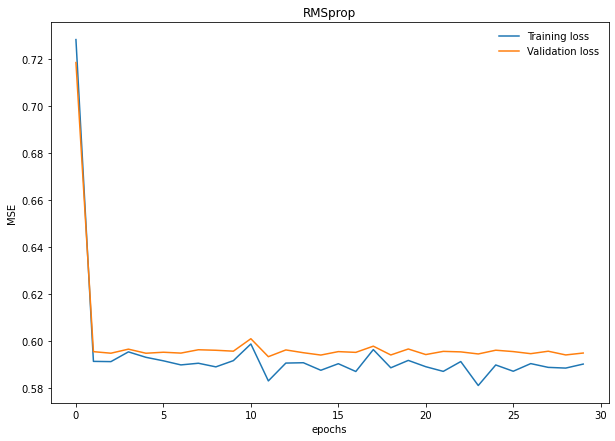

In [14]:
plot_loss('RMSprop', train_losses, test_losses)

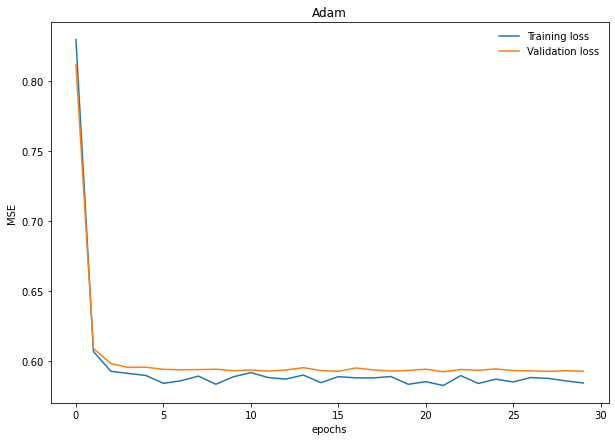

In [19]:
plot_loss('Adam', train_losses, test_losses)

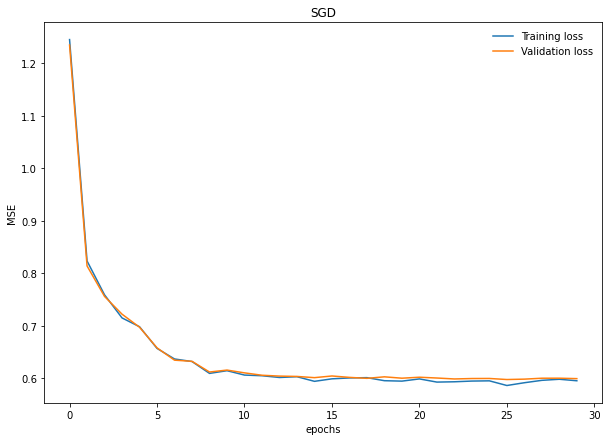

In [23]:
plot_loss('SGD', train_losses, test_losses)

По графикам легко заметить, что RMSprop и Adam сходятся намного быстрее SGD. Но вот сравнить их между собой на данном примере довольно сложно, результаты очень близки